# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 9.3 MB/s eta 0:00:00


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    DivisiblePadd,
    SqueezeDimd,
    Resized,
    SpatialCropD,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, VNet, SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, PatchIterd, GridPatchDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [3]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Setup imports

In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpp26lzr9z


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:35, 45.4MB/s]                            

2023-01-16 19:24:21,746 - INFO - Downloaded: /tmp/tmpbd6fwkg5/Task09_Spleen.tar


2023-01-16 19:24:24,941 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-01-16 19:24:24,942 - INFO - Writing into directory: /tmp/tmpbd6fwkg5.


## Set MSD Spleen dataset path

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path1='/content/drive/My Drive/Dataset/DATA/Img/thigh'
file_path2='/content/drive/My Drive/Dataset/DATA/Label/thigh'

In [7]:
train_images = sorted(
    glob.glob(os.path.join(file_path1, "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(file_path2, "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-6], data_dicts[-6:]

In [9]:
print(val_files)

[{'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM77PS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM77PS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM78BP.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM78BP.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM81LS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM81LS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM85GN.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM85GN.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM90AE.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM90AE.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM93AC.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM93AC.nii.gz'}]


In [9]:
print(data_dicts)

[{'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM03SF.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM03SF.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM04SD.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM04SD.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM05AA.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM05AA.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM06ML.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM06ML.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM07NP.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM07NP.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM08GA.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM08GA.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM13AB.nii.gz', 'label': '/content/drive/

## Set deterministic training for reproducibility

In [10]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [8]:
import numpy as np

In [9]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #SpatialCropD(keys=["label"], roi_start=(0,0,0), roi_end=(224,224,48)),

        # user can also add other random transforms

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),


    ]
)

## Check transforms in DataLoader

image shape: torch.Size([320, 240, 48]), label shape: torch.Size([320, 240, 48])


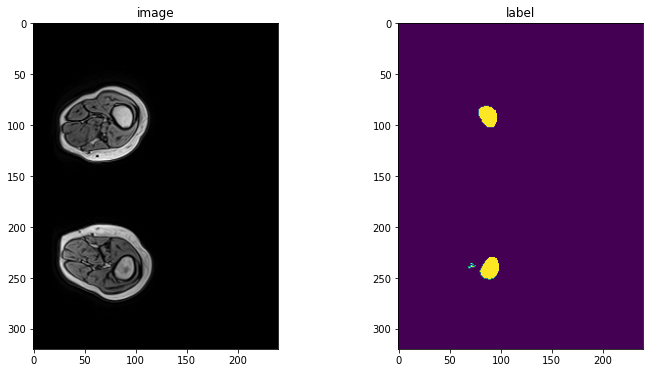

In [17]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 20])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


image shape: torch.Size([320, 240]), label shape: torch.Size([320, 240])


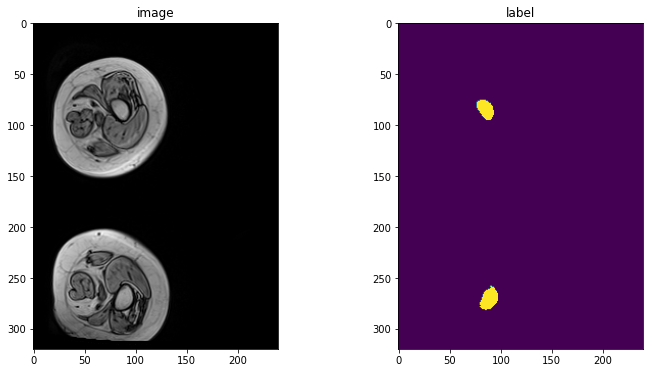

In [18]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
patch_func = PatchIterd(
    keys=["image", "label"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[320, 240]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_train_ds = GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
patch_val_ds = GridPatchDataset(
    data=val_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_loader = DataLoader(
    patch_train_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    patch_val_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)
plt.show()

## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [11]:
from tqdm import tqdm
from sklearn.model_selection import KFold

In [12]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      print(f'Reset trainable parameters of layer = {layer}')
      layer.reset_parameters()

In [13]:
k_folds = 5
num_epochs = 1
results = {}
  
# Set fixed random number seed
torch.manual_seed(42)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
    
# Start print
print('--------------------------------')

--------------------------------


In [21]:
whole_ds = CacheDataset(
    data=data_dicts, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
patch_func = PatchIterd(
    keys=["image", "label"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[320, 240]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_whole_ds = GridPatchDataset(
    data=whole_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)

Loading dataset: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


In [14]:
patch_whole_ds = Dataset(data=data_dicts[-5:], transform=val_transforms)

In [ ]:
max_epochs = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
for fold, (train_ids, test_ids) in enumerate(kfold.split(patch_whole_ds)):
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
    
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                      patch_whole_ds, 
                      batch_size=1, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                      patch_whole_ds,
                      batch_size=1, sampler=test_subsampler)
  model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3).to(device)
  model.apply(reset_weights)
  optimizer = torch.optim.Adam(model.parameters(), 1e-4)
  for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    i = 0
    for batch_data in trainloader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        i = i+1
        print(i,' of total training sample',int(len(patch_whole_ds)*0.8))
        print(
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in testloader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = model(val_inputs)
                val_outputs = [post_pred(i) for i in val_outputs]
                val_labels = [post_label(i) for i in val_labels]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
sum = 0.0
for value in metric_values:
  sum += value
print(f'Average: {sum/len(metric_values)} %')


FOLD 0
--------------------------------
Reset trainable parameters of layer = BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
Reset trainable parameters of layer = BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
Reset trainable parameters of layer = Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
Reset trainable parameters of layer = BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(64, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
Reset tr

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

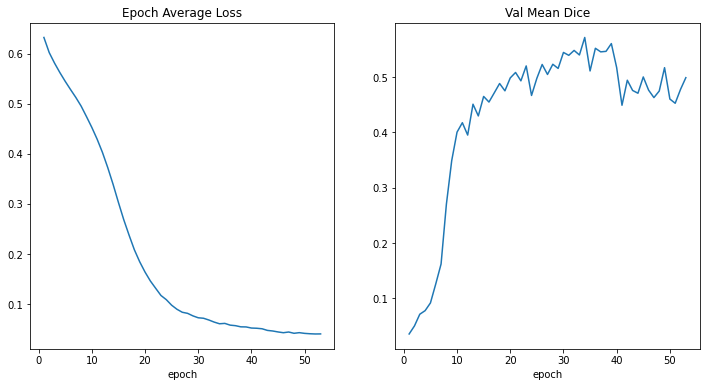

In [23]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [36]:
from monai.inferers import SliceInferer
from monai.visualize import matshow3d

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


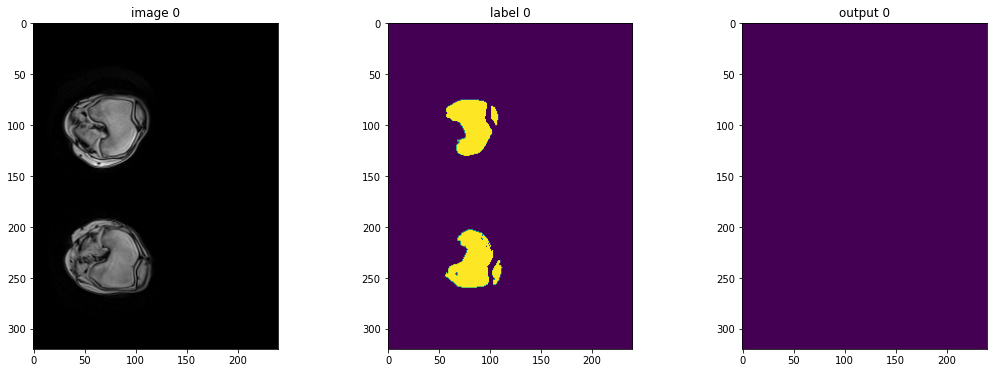

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


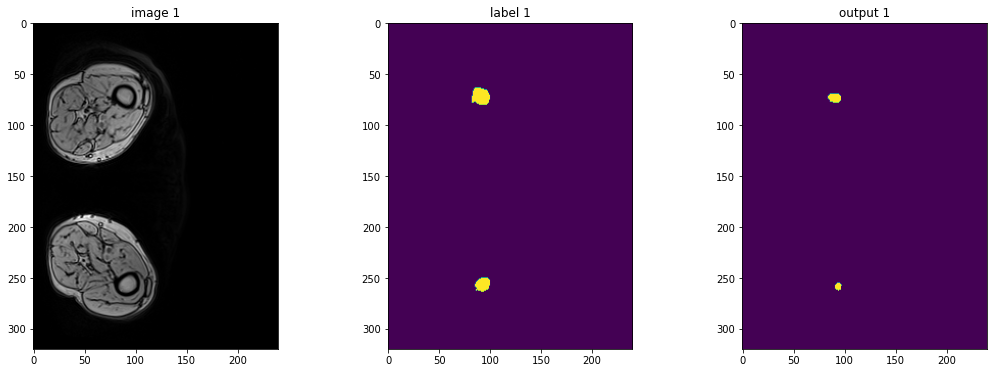

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


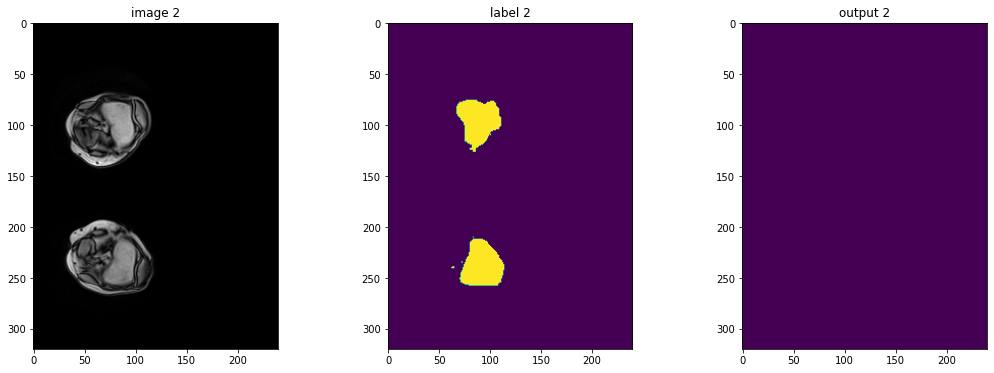

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


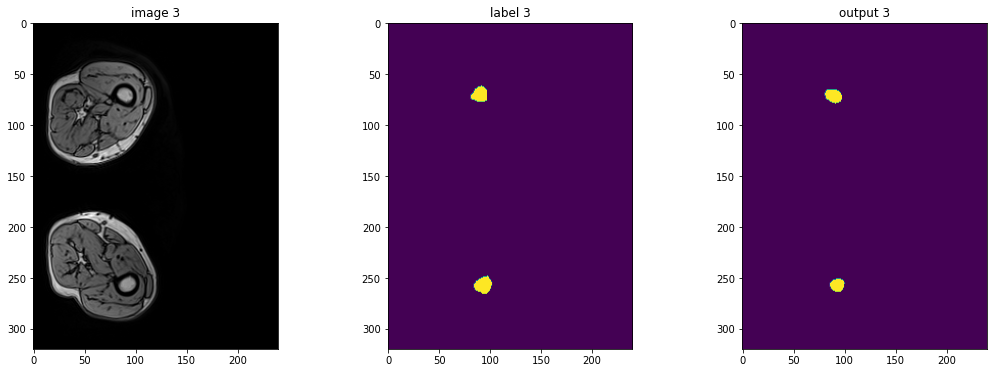

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


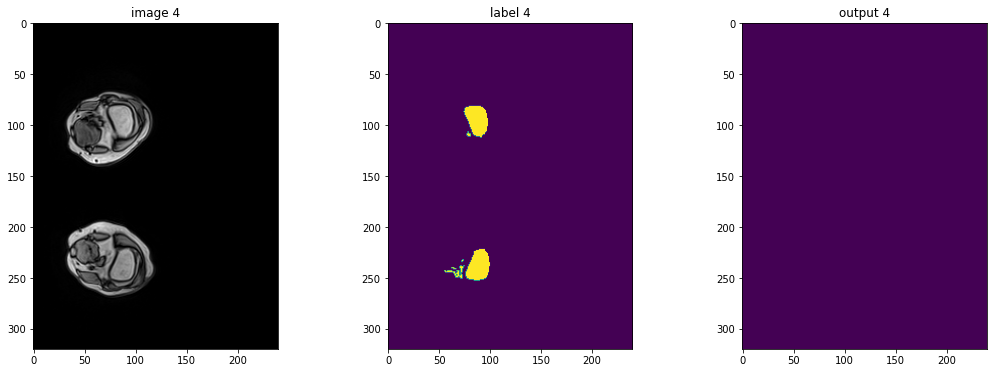

torch.Size([4, 1, 320, 240])
torch.Size([4, 2, 320, 240])


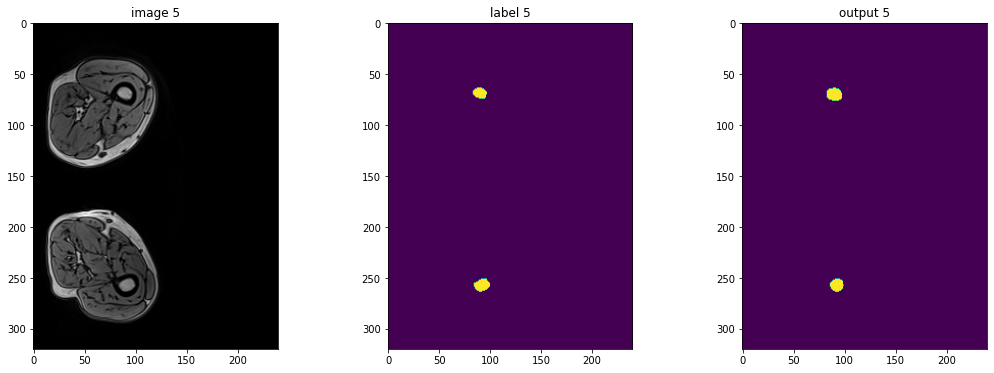

In [48]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][1, 0, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][1, 0, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        print(val_data["image"].shape)
        print(val_outputs.shape)
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[1, :, :])
        plt.show()
        if i == 5:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            2, 2, 2), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        DivisiblePadd(["image", "label"], 16),

    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys=["pred","label"],
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys=["pred_meta_dict", "label_meta_dict"],
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
        device="cpu",
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.33623823523521423


## Inference on Test Set

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[0][:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)